# Introduction

The Jaynes-Cumming model is the simplest possible model of quantum mechanical light-matter interaction, describing a single two-level atom interacting with a single electromagnetic cavity mode. The Hamiltonian for this system is (in dipole interaction form)

### $H = \hbar \omega_c a^\dagger a + \frac{1}{2}\hbar\omega_a\sigma_z + \hbar g(a^\dagger + a)(\sigma_- + \sigma_+)$

or with the rotating-wave approximation

### $H_{\rm RWA} = \hbar \omega_c a^\dagger a + \frac{1}{2}\hbar\omega_a\sigma_z + \hbar g(a^\dagger\sigma_- + a\sigma_+)$

where $\omega_c$ and $\omega_a$ are the frequencies of the cavity and atom, respectively, and $g$ is the interaction strength.

In [1]:
def plot_qfunc(rho, fig=None, ax=None, figsize=(6, 6),
                cmap=None, alpha_max=7.5, colorbar=False, projection='2d'):
    """
    Plot the the Wigner function for a density matrix (or ket) that describes
    an oscillator mode.

    Parameters
    ----------
    rho : :class:`qutip.qobj.Qobj`
        The density matrix (or ket) of the state to visualize.

    fig : a matplotlib Figure instance
        The Figure canvas in which the plot will be drawn.

    ax : a matplotlib axes instance
        The axes context in which the plot will be drawn.

    figsize : (width, height)
        The size of the matplotlib figure (in inches) if it is to be created
        (that is, if no 'fig' and 'ax' arguments are passed).

    cmap : a matplotlib cmap instance
        The colormap.

    alpha_max : float
        The span of the x and y coordinates (both [-alpha_max, alpha_max]).

    colorbar : bool
        Whether (True) or not (False) a colorbar should be attached to the
        Wigner function graph.

    method : string {'clenshaw', 'iterative', 'laguerre', 'fft'}
        The method used for calculating the wigner function. See the
        documentation for qutip.wigner for details.

    projection: string {'2d', '3d'}
        Specify whether the Wigner function is to be plotted as a
        contour graph ('2d') or surface plot ('3d').

    Returns
    -------
    fig, ax : tuple
        A tuple of the matplotlib figure and axes instances used to produce
        the figure.
    """

    if not fig and not ax:
        if projection == '2d':
            fig, ax = plt.subplots(1, 1, figsize=figsize)
        elif projection == '3d':
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(1, 1, 1, projection='3d')
        else:
            raise ValueError('Unexpected value of projection keyword argument')

    if isket(rho):
        rho = ket2dm(rho)

    xvec = np.linspace(-alpha_max, alpha_max, 200)
    Q0 = qfunc(rho, xvec, xvec)

    Q, yvec = Q0 if type(Q0) is tuple else (Q0, xvec)

    qlim = abs(Q).max()

    if cmap is None:
        cmap = cm.get_cmap('RdBu')

    if projection == '2d':
        cf = ax.contourf(xvec, yvec, Q, 100,
                         norm=mpl.colors.Normalize(-qlim, qlim), cmap=cmap)
    elif projection == '3d':
        X, Y = np.meshgrid(xvec, xvec)
        cf = ax.plot_surface(X, Y, Q0, rstride=5, cstride=5, linewidth=0.5,
                             norm=mpl.colors.Normalize(-qlim, qlim), cmap=cmap)
    else:
        raise ValueError('Unexpected value of projection keyword argument.')

    if xvec is not yvec:
        ax.set_ylim(xvec.min(), xvec.max())

    ax.set_xlabel(r'$\rm{Re}(\alpha)$', fontsize=12)
    ax.set_ylabel(r'$\rm{Im}(\alpha)$', fontsize=12)

    if colorbar:
        fig.colorbar(cf, ax=ax)

    ax.set_title("Husimi Q-function", fontsize=12)

    return fig, ax

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from numpy import linalg
from scipy.linalg import expm as expmm
from tqdm import tqdm

wc = 1.0  # cavity frequency
wa = 1.0  # atom frequency
g  = 0.05 * 2 * np.pi  # coupling strength
kappa = 0.0       # cavity dissipation rate
gamma = 0.0        # atom dissipation rate
N = 10              # number of cavity fock states
n_th_a = 0.0        # avg number of thermal bath excitation
use_rwa = True

T = 1 / wc
r = 1/2
Tk = r * T
mu = 20j

# operators
a  = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), create(2)) 
sp = sm.dag()
sz = sp*sm - sm*sp

# Hamiltonian
if use_rwa:
    H = wc * a.dag() * a + wa * sz/2 + g * (a.dag() * sm + a * sp)
    H0 = wc * a.dag() * a + wa * sz/2
    Hint = g * (a.dag() * sm + a * sp)
else:
    H = wc * a.dag() * a + wa * sp*sm + g * (a.dag() + a) * (sm + sm.dag())
#print(H)
Hk = g*(np.conj(mu)*sm + mu*sp)
#print(Hk)

## Собственные значения и собственные функции гамильтониана Джейнса-Каммингса

In [3]:
HJC = np.asarray(H)
eigenValues, eigenVectors = linalg.eigh(HJC)

idx = eigenValues.argsort()   
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
#print(Qobj(eigenValues))
#print(Qobj(eigenVectors))

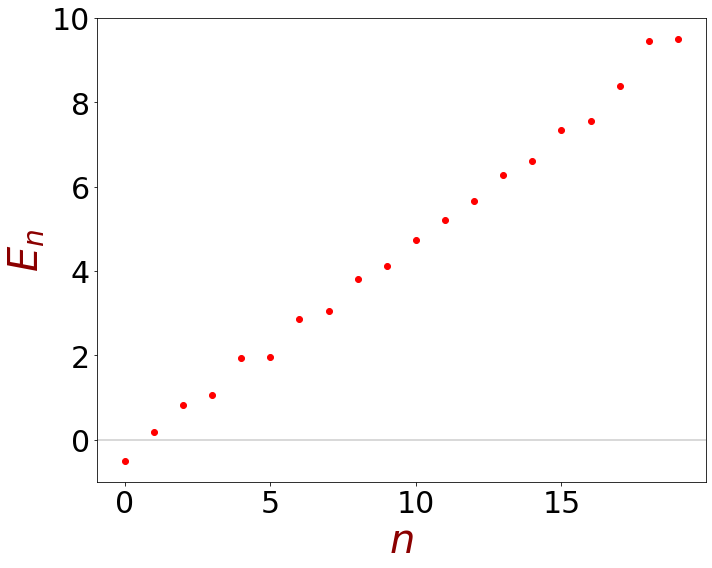

In [4]:
textsize = 30
#  plot for (p, x)
fig = plt.figure(figsize=(10,8))

font = {'family': 'helvetica',
        'color':  'darkred',
        'weight': 'bold',
        'size': textsize+10,
        }

fontTitle = {'family': 'helvetica',
        'color':  'darkred',
        'weight': 'bold',
        'size': textsize,
        }

plt.plot(eigenValues, 'ro')
plt.axhline(y=0, lw=0.3, c='k')
plt.xlabel('$n$', fontdict=font)
plt.ylabel('$E_n$', fontdict=font)
plt.tick_params(labelsize=textsize)
#plt.grid()
plt.tight_layout()
fig.savefig('images/quantum/coherent/energy_spectrum,' + 'g=' + str(g) + ',N=' + str(N) + ',mu=' + str(mu) + 
            ',r=' + str(r) + '.png', dpi=150)
plt.show()

<Figure size 432x288 with 0 Axes>

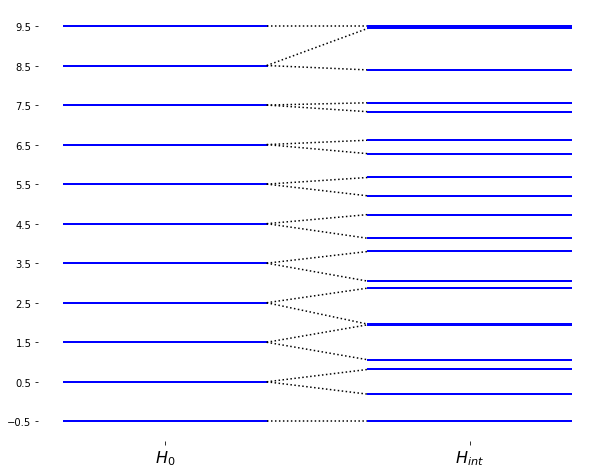

In [5]:
plt.figure()
plot_energy_levels([H0, Hint], figsize=(10,8), labels=['$H_{0}$', '$H_{int}$'], show_ylabels=True)
plt.savefig('images/quantum/coherent/energy_levels,' + 'g=' + str(g) + ',N=' + str(N) + ',mu=' + str(mu) + 
            ',r=' + str(r) + '.png', dpi=150)

In [13]:
psis = []
for i in range(N-1, 0, -1):
    psis.append(tensor(coherent(N,np.sqrt(i-1)), basis(2,0)))    #N-1  e
    psis.append(tensor(coherent(N,np.sqrt(i)), basis(2,1)))  #N  g
psis[0]
start = psis[0]
onestart = psis[1]


In [6]:
start = tensor(coherent(N,np.sqrt(N-1)), basis(2,0))
onestart = tensor(fock(N,N-1), basis(2,1))

In [7]:
def f1(t): 
    step1 = (-1j*H*t).expm()*start
    step2 = start.trans()*step1
    return step1, step2

def f2(t): 
    step1 = (-1j*H*t).expm()*start
    step2 = onestart.trans()*step1
    return step1, step2

100%|██████████| 101/101 [00:00<00:00, 535.64it/s]


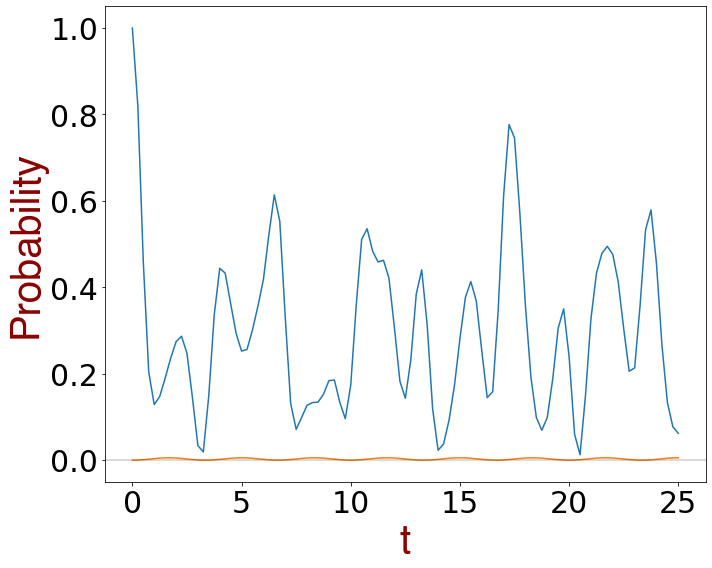

In [8]:
t = np.linspace(0, 25, 101)
f1(0)
p1 = [abs(complex(np.array(f1(i)[1])))**2 for i in tqdm(t)]
p2 = [abs(complex(np.array(f2(i)[1])))**2 for i in tqdm(t)]

fig = plt.figure(figsize=(10,8))
plt.plot(t, p1, '-', label=r'$\left | 0, e \right>$')
plt.plot(t, p2, '-', label=r'$\left | 1, g \right>$')
plt.axhline(y=0, lw=0.3, c='k')
plt.ylabel('Probability', fontdict=font)
plt.xlabel('t', fontdict=font)
plt.tick_params(labelsize=textsize)
#plt.grid()
plt.tight_layout()
fig.savefig('images/quantum/coherent/probdistJC,' + 'g=' + str(g) + ',N=' + str(N) + ',mu=' + str(mu) + 
            ',r=' + str(r) + '.png', dpi=150)
plt.show()

In [9]:
n_c = [f1(i)[0] for i in t]
n_a = [f2(i)[0] for i in t]
sx = tensor(qeye(N), sigmax())
sy = tensor(qeye(N), sigmay())
sz = tensor(qeye(N), sigmaz())

vec = [expect(sx, n_c), expect(sy, n_c), expect(sz, n_c)]
print(shape(vec)[1])

101


<Figure size 432x288 with 0 Axes>

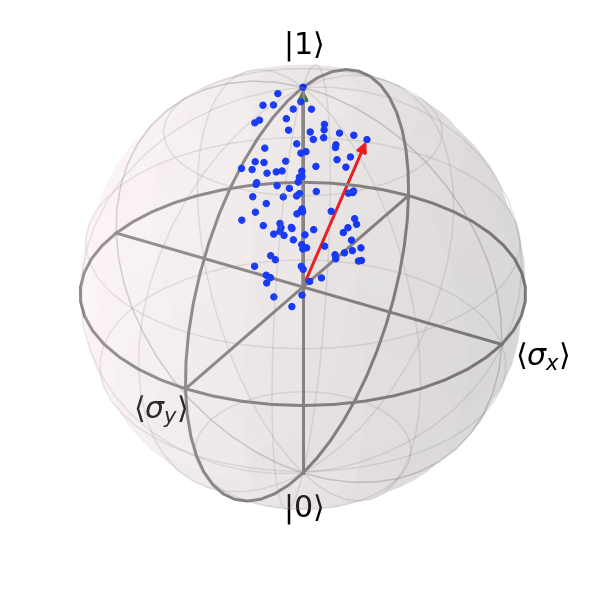

In [10]:
import matplotlib as mpl
from pylab import *
from matplotlib import cm
import imageio
import mayavi

#plt.plot([np.sqrt(sum(abs(np.asarray(states[i]))**2)) for i in range(len(states))], 'o', markersize=1)
#plt.show()

colors = ['blue' for i in range(shape(vec)[1])]
colors[-1] = 'red'
colors[0] = 'lime'
#print(colors)

b = qutip.Bloch(figsize=(8,8))


## customize sphere properties ##
b.point_color = colors # options: 'r', 'g', 'b' etc.
b.vector_color = ['green', 'red']
b.point_marker = ['o']
b.point_size = [40]
b.xlabel = [r'$\left<\sigma_y\right>$', ''] 
b.ylabel = [r'$\left<\sigma_x\right>$', '']
b.zlabel = [r'$\left|1\right>$', r'$\left|0\right>$']
b.frame_width = 3
b.sphere_alpha = 0.12

#b.add_states(states, 'point'
b.add_points(vec)
#b.add_points(vec, 'l')
b.add_vectors([vec[0][0], vec[1][0], vec[2][0]])
b.add_vectors([vec[0][-1], vec[1][-1], vec[2][-1]])
b.font_size = 30

nrm=mpl.colors.Normalize(-2,10)
colors=cm.jet(nrm(t))
colors = list(colors)
#colors[-1] = 'red'
#colors[0] = 'lime'
## add data points from expectation values ##
## customize sphere properties ##
b.point_color=colors

plt.tight_layout()
#b.view = [60, 60]

b.render()

bb = b.fig
bb.savefig('images/quantum/coherent/qubitJC,' + 'g=' + str(g) + ',N=' + str(N) + ',mu=' + str(mu) + 
            ',r=' + str(r) + '.png', dpi=150)

## Husimi Q-function

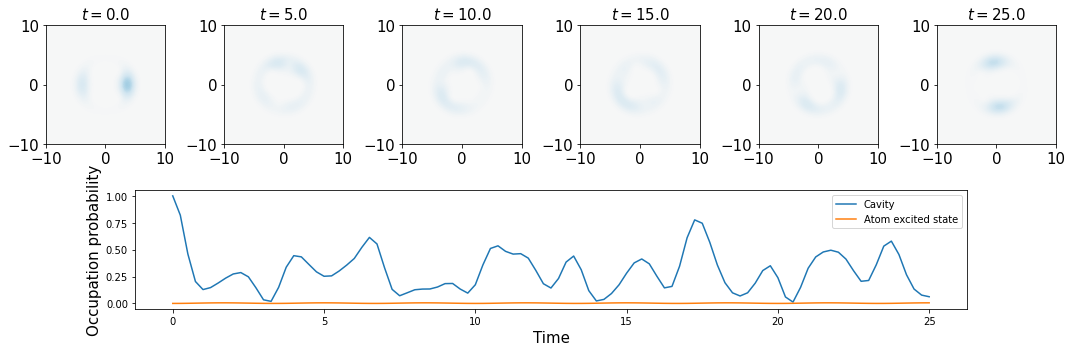

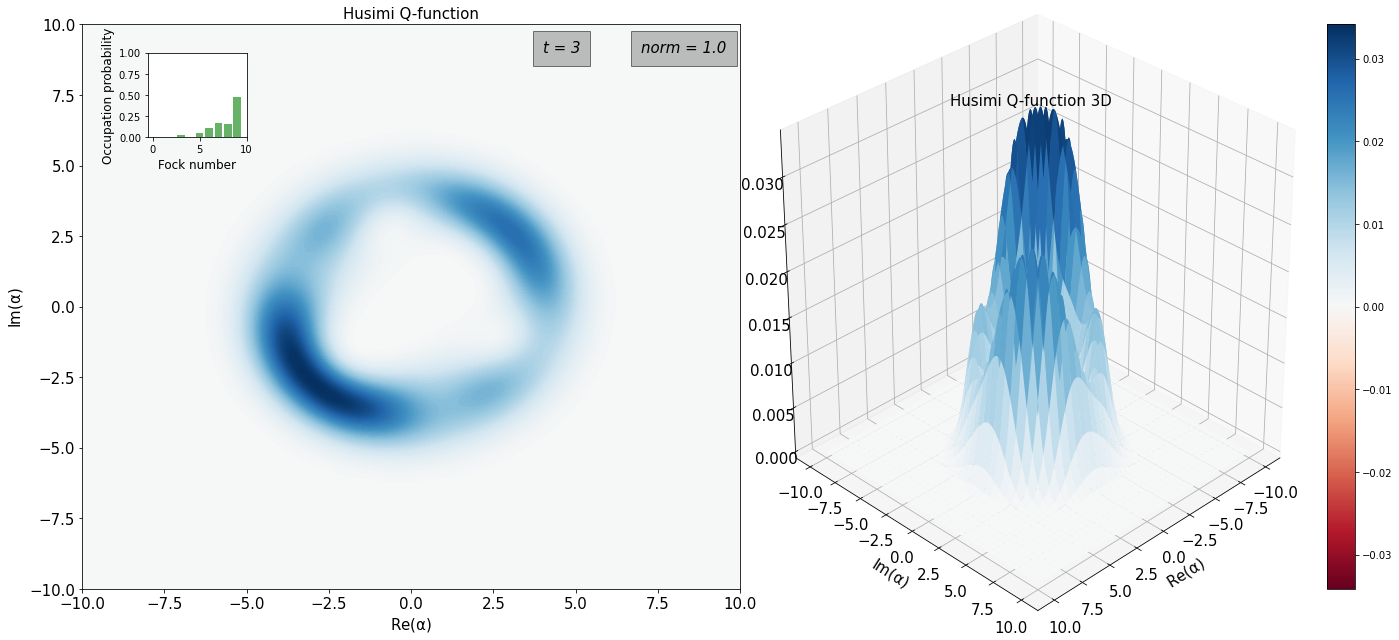

In [11]:
def plot_q_2d_3d(t, rho, alpha):
    #fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(12, 6))
    fig = plt.figure(figsize=(20, 9))
    
    rho_cavity = ptrace(rho[t], 0)
    ax1 = fig.add_subplot(1, 2, 1)
    plot_qfunc(rho_cavity, fig=fig, ax=ax1, alpha_max=alpha)
    ax2 = ax1.inset_axes([0.1, 0.8, 0.15, 0.15])
    ax1.text(-3 + alpha, alpha - 1, 'norm = ' +
             str(np.round(abs(np.array(trace(rho_cavity))),3)), style='italic', 
             fontsize=textsize/2, bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
    ax1.text(-6 + alpha, alpha - 1, 't = ' + str(t), style='italic', 
             fontsize=textsize/2, bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
    plot_fock_distribution(rho_cavity, fig=fig, ax=ax2)
    plt.tick_params(labelsize=textsize/2)
    ax1.xaxis.label.set_size(textsize/2)
    ax1.yaxis.label.set_size(textsize/2)
    ax1.set_title('Husimi Q-function', fontsize=textsize/2)
    
    ax3 = fig.add_subplot(1, 2, 2, projection='3d')
    plot_qfunc(rho_cavity, fig=fig, ax=ax3, projection='3d', alpha_max=alpha, colorbar=True)
    ax3.view_init(30, 45)
    plt.tick_params(labelsize=textsize/2)
    ax3.xaxis.label.set_size(textsize/2)
    ax3.yaxis.label.set_size(textsize/2)
    ax3.set_title('Husimi Q-function 3D', fontsize=textsize/2)
    ax3.dist = 8.4
    plt.subplots_adjust(wspace=0.1)
    plt.tight_layout()
    plt.close(fig)
    return fig

alpha = 10
t_idx = np.where([t == i for i in [0.0, 5.0, 10, 15, 20, 25]])[1]
rho_list = [n_c[x] for x in t_idx]
xvec = np.linspace(-alpha,alpha,100)
fig_grid = (2, len(rho_list)*2)
fig = plt.figure(figsize=(2.5*len(rho_list),5))

for idx, rho in enumerate(rho_list):
    rho_cavity = ptrace(rho, 0)
    Q = qfunc(rho_cavity, xvec, xvec)
    ax = plt.subplot2grid(fig_grid, (0, 2*idx), colspan=2)
    ax.contourf(xvec, xvec, Q, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
    ax.set_title(r"$t = %.1f$" % t[t_idx][idx], fontsize=textsize/2)
    plt.tight_layout()
    plt.tick_params(labelsize=textsize/2)

# plot the cavity occupation probability in the ground state
ax = plt.subplot2grid(fig_grid, (1, 1), colspan=(fig_grid[1]-2))
ax.plot(t, p1, label="Cavity")
ax.plot(t, p2, label="Atom excited state")
ax.legend()
ax.set_xlabel('Time', fontsize=textsize/2)
ax.set_ylabel('Occupation probability', fontsize=textsize/2)
plt.tight_layout()
fig.savefig('images/quantum/coherent/HusimiJC,' + 'g=' + str(g) + ',N=' + str(N) + ',mu=' + str(mu) + 
            ',r=' + str(r) + '.png', dpi=150)
plt.show()


rho = rho_list
fig = plot_q_2d_3d(3, rho, alpha)
fig.savefig('images/quantum/coherent/Husimi2d3dJC,' + 'g=' + str(g) + ',N=' + str(N) + ',mu=' + str(mu) + 
            ',r=' + str(r) + '.png', dpi=150)
fig

# Kicked Jaynes-Cummings

In [14]:
nT = 200  #  количество периодов
probs = []
psinT = []
for i in tqdm(range(len(psis))):
    prob = []
    psit = []
    for n in range(nT):
        step1 = (-1j*H*n*Tk*g).expm()*(-1j*Hk*n).expm()*start
        step2 = np.abs(complex(np.asarray(psis[i].trans().conj()*step1)))**2
        psit.append(step1)
        prob.append(step2)
    psinT.append(psit)
    probs.append(prob)
norms = [psinT[0][i].norm() for i in range(len(psinT[0]))]

100%|██████████| 18/18 [00:11<00:00,  1.62it/s]


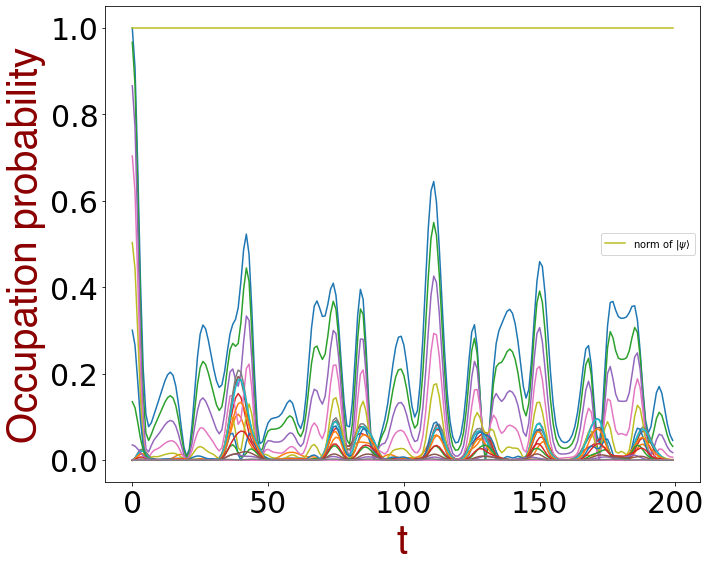

<Figure size 432x288 with 0 Axes>

In [15]:
states = psinT[0]

vec = [expect(sx, states), expect(sy, states), expect(sz, states)]

plt.figure(figsize=(10,8))
if N <= 2:
    plt.plot(probs[0], label='$|$' + str(N-2) + r'$,e \rangle$')
    plt.plot(probs[1], label='$|$' + str(N-1) + r'$,g \rangle$')
    #plt.plot(probs[2], label=r'$\left | N, g \right>$')
    #plt.plot(probs[3], label=r'$\left | N+1, e \right>$')
else:
    for x in probs:
        plt.plot(x)
plt.xlabel('t', fontdict=font)
plt.ylabel('Occupation probability', fontdict=font)
plt.plot(norms, label='norm of ' + r'$\left|\psi\right>$')
plt.tick_params(labelsize=textsize)
plt.legend()
#plt.grid()
plt.tight_layout()
plt.show()
plt.savefig('images/quantum/coherent/probdistKJC,' + 'g=' + str(g) + ',N=' + str(N) + ',mu=' + str(mu) + 
            ',r=' + str(r) + '.png', dpi=150)

<Figure size 432x288 with 0 Axes>

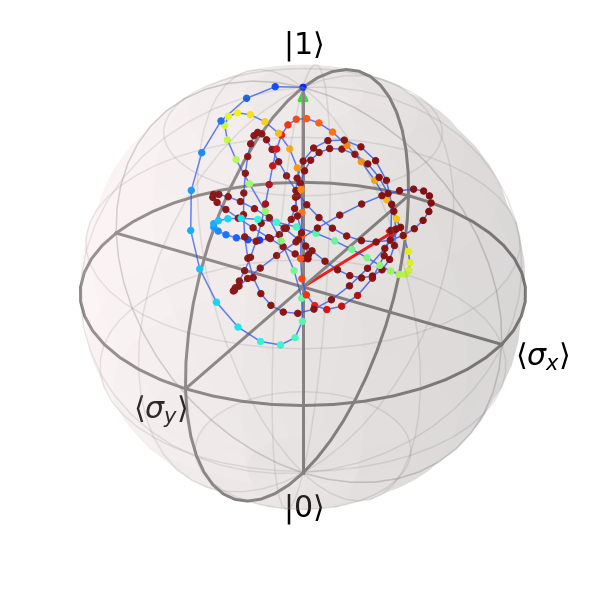

In [16]:
#plt.plot([np.sqrt(sum(abs(np.asarray(states[i]))**2)) for i in range(len(states))], 'o', markersize=1)
#plt.show()

colors = ['blue' for i in range(len(states))]
colors[-1] = 'red'
colors[0] = 'lime'
#print(colors)

b = qutip.Bloch(figsize=(8,8))

## customize sphere properties ##
b.point_color = colors # options: 'r', 'g', 'b' etc.
b.vector_color = ['lime', 'red']
b.point_marker = ['o']
b.point_size = [40]
b.xlabel = [r'$\left<\sigma_y\right>$', ''] 
b.ylabel = [r'$\left<\sigma_x\right>$', '']
b.zlabel = [r'$\left|1\right>$', r'$\left|0\right>$']
b.frame_width = 3
b.sphere_alpha = 0.12

#b.add_states(states, 'point'
b.add_points(vec, 'o')
b.add_points(vec, 'l')
b.add_vectors([vec[0][0], vec[1][0], vec[2][0]])
b.add_vectors([vec[0][-1], vec[1][-1], vec[2][-1]])
b.font_size = textsize

nrm=mpl.colors.Normalize(-2,10)
colors=cm.jet(nrm(t))
colors = list(colors)
#colors[-1] = 'red'
#colors[0] = 'lime'
## add data points from expectation values ##
## customize sphere properties ##
b.point_color=colors

plt.tight_layout()
#b.view = [60, 60]

b.render()

bb = b.fig
bb.savefig('images/quantum/coherent/qubitKJC,' + 'g=' + str(g) + ',N=' + str(N) + ',mu=' + str(mu) + 
            ',r=' + str(r) + '.png', dpi=150)

In [ ]:
import os


def animate_bloch(vec, duration=0.1, save_all=False):

    b = Bloch(figsize=(12, 12))
    b.vector_color = ['r']
    #b.view = [-40,30]
    images=[]
    try:
        length = shape(vec)[1]
    except:
        length = 1
        vec = [vec]
    ## normalize colors to the length of data ##
    nrm = mpl.colors.Normalize(0,length)
    colors = cm.jet(nrm(range(length))) # options: cool, summer, winter, autumn etc.

    ## customize sphere properties ##
    b.point_color = list(colors) # options: 'r', 'g', 'b' etc.
    b.point_marker = ['o']
    b.point_size = [40]
    b.xlabel = [r'$\left<\sigma_y\right>$', ''] 
    b.ylabel = [r'$\left<\sigma_x\right>$', '']
    b.zlabel = [r'$\left|1\right>$', r'$\left|0\right>$']
    b.frame_width = 3
    b.sphere_alpha = 0.12
    b.font_size = textsize
    
    for i in tqdm(range(length)):
        b.clear()
        b.add_vectors([vec[0][i], vec[1][i], vec[2][i]])
        b.add_points([vec[0][:(i+1)], vec[1][:(i+1)], vec[2][:(i+1)]], 'm')
        b.add_points([vec[0][:(i+1)], vec[1][:(i+1)], vec[2][:(i+1)]], 'l')
        if save_all:
            b.save(dirc='tmp') #saving images to tmp directory
            filename="tmp/bloch_%01d.png" % i
        else:
            filename='temp_file.png'
            b.save(filename)
        images.append(imageio.imread(filename))
        os.remove(filename)
    imageio.mimsave('images/quantum/coherent/bloch_animKJC,' + 'g=' +
                    str(g) + ',N=' + str(N) + ',mu=' + str(mu) + 
            ',r=' + str(r) + '.gif', images, duration=duration)

In [ ]:
animate_bloch(vec, duration=0.1, save_all=False)

## Plot 3D Bloch sphere

In [ ]:
%%time
b = Bloch3d()

colors = ['blue' for i in range(len(states))]
colors[-1] = 'red'
colors[0] = 'lime'

## customize sphere properties ##
b.point_color = colors # options: 'r', 'g', 'b' etc.
b.vector_color = ['green', 'red']
b.point_size = 0.055
#b.add_points([n[0][0],n[1][0],n[2][0]]) # <-- add a 'm' string to signify 'multi' colored points
[b.add_points([vec[0][i],vec[1][i],vec[2][i]], 's') for i in range(len(states))]
b.sphere_color='0.1'
b.sphere_alpha=0.1
#b.render()
#b.show()

## Husimi Q-function

<ipython-input-17-fc883bc25e43>:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes


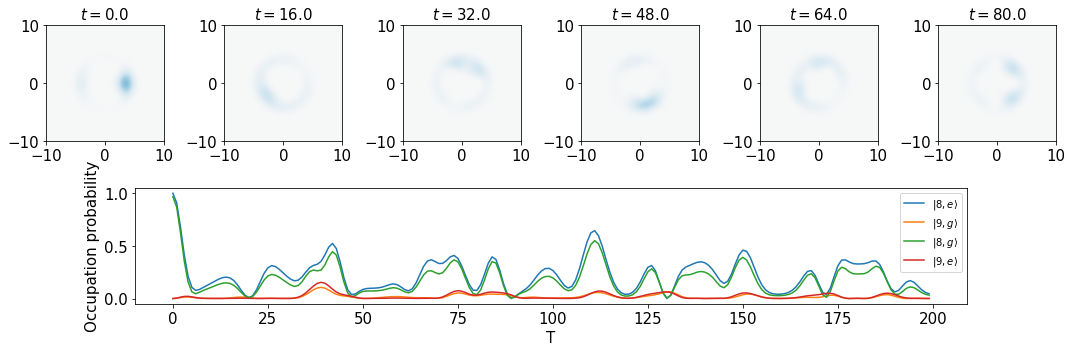

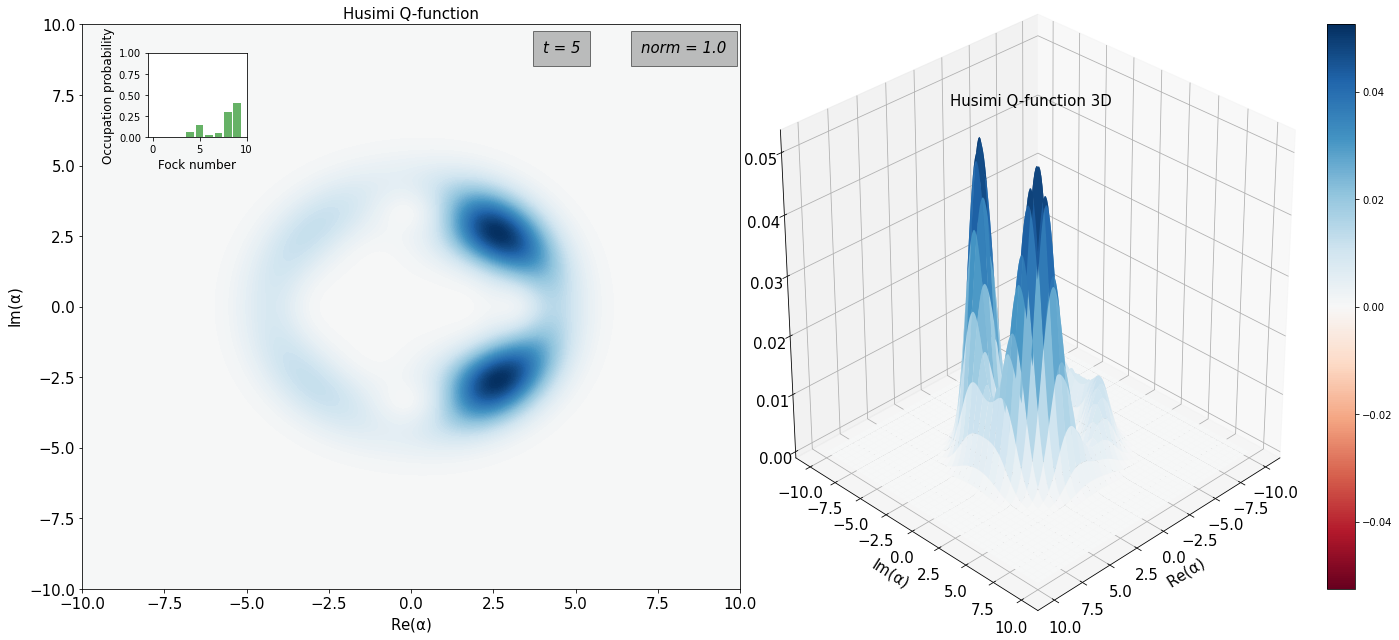

In [17]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from mpl_toolkits.mplot3d import axes3d


Tlist = np.arange(0, nT, 1)
t_idx = np.where([Tlist == t for t in [0.0, 16.0, 32, 48, 64, 80]])[1]
rho_list = [psinT[0][x] for x in t_idx]

fig_grid = (2, len(rho_list)*2)
fig = plt.figure(figsize=(2.5*len(rho_list),5))

for idx, rho in enumerate(rho_list):
    rho_cavity = ptrace(rho, 0)
    #print(rho_cavity)
    Q = qfunc(rho_cavity, xvec, xvec)
    ax = plt.subplot2grid(fig_grid, (0, 2*idx), colspan=2)
    ax.contourf(xvec, xvec, Q, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
    ax.set_title(r"$t = %.1f$" % Tlist[t_idx][idx], fontsize=textsize/2)
    plt.tight_layout()
    plt.tick_params(labelsize=textsize/2)

# plot the cavity occupation probability in the ground state
if N <= 2:   
    ax = plt.subplot2grid(fig_grid, (1, 1), colspan=(fig_grid[1]-2))
    ax.plot(Tlist, probs[0], label='$|$' + str(N-2) + r'$,e \rangle$')
    ax.plot(Tlist, probs[1], label='$|$' + str(N-1) + r'$,g \rangle$')
    ax.legend()
else:
    ax = plt.subplot2grid(fig_grid, (1, 1), colspan=(fig_grid[1]-2))
    ax.plot(Tlist, probs[0], label='$|$' + str(N-2) + r'$,e \rangle$')
    ax.plot(Tlist, probs[1], label='$|$' + str(N-1) + r'$,g \rangle$')
    ax.plot(Tlist, probs[2], label='$|$' + str(N-2) + r'$,g \rangle$')
    ax.plot(Tlist, probs[3], label='$|$' + str(N-1) + r'$,e \rangle$')
    ax.legend()
ax.set_xlabel('T', fontsize=textsize/2)
ax.set_ylabel('Occupation probability', fontsize=textsize/2)
plt.tick_params(labelsize=textsize/2)
#plt.grid()
plt.tight_layout()
fig.savefig('images/quantum/coherent/husimiKJC,' + 'g=' + str(g) + ',N=' + str(N) + ',mu=' + str(mu) + 
            ',r=' + str(r) + '.png', dpi=150)
plt.show()


rho = rho_list
fig = plot_q_2d_3d(5, rho, alpha)

fig.savefig('images/quantum/coherent/husimi2d3dKJC,' + 'g=' + str(g) + ',N=' + str(N) + ',mu=' + str(mu) + 
            ',r=' + str(r) + '.png', dpi=150)
fig

In [ ]:
import os
from tqdm import tqdm


def animate_q(vec, duration=0.1, save_all=False):
    images=[]
    try:
        length = len(vec)
    except:
        length = 1
        vec = vec
    rho_list = [vec[x] for x in range(length)]
    for i in tqdm(range(length)):
        
        q = plot_q_2d_3d(i, rho_list, alpha)

        #plt.close(fig)
        if save_all:
            q.savefig(dirc='tmp') #saving images to tmp directory
            filename="tmp/husimi_%01d.png" % i
        else:
            filename='husimi_temp_file.png'
            q.savefig(filename)
        images.append(imageio.imread(filename))
        os.remove(filename)
    imageio.mimsave('images/quantum/coherent/husimi_animKJC,' + 'g=' + str(g) + 
                    ',N=' + str(N) + ',mu=' + str(mu) + 
            ',r=' + str(r) + '.gif', images, duration=duration)

In [19]:
PSI = psinT[0]
animate_q(psinT[0], duration=0.15)

NameError: name 'animate_q' is not defined

In [ ]:
from IPython.display import Image
Image(url='images/quantum/coherent/husimi_animKJC,' + 'g=' + str(g) + 
                    ',N=' + str(N) + ',mu=' + str(mu) + 
            ',r=' + str(r) + '.gif') 

In [18]:
theta = np.linspace(0, np.pi, 50)
phi = np.linspace(0, 2 * np.pi, 50)

Q, THETA, PHI = spin_q_function(PSI[0], theta, phi)

NameError: name 'PSI' is not defined

In [ ]:
plot_spin_distribution_2d(Q, THETA, PHI);

In [ ]:
fig, ax = plot_spin_distribution_3d(Q, THETA, PHI);

ax.view_init(15, 30)

In [ ]:
theta = np.linspace(0, np.pi, 50)
phi = np.linspace(0, 2 * np.pi, 50)

def plot_spin_wigner_2d_3d(rho):
    
    W, THETA, PHI = spin_wigner(rho, theta, phi)
    fig = plt.figure(figsize=(20,9))

    ax1 = fig.add_subplot(1, 2, 1)
    f1, a1 = plot_spin_distribution_2d(W.real, THETA, PHI, fig=fig, ax=ax1)
    plt.tick_params(labelsize=textsize/2)
    ax1.xaxis.label.set_size(textsize/2)
    ax1.yaxis.label.set_size(textsize/2)
    #ax1.set_title('Wigner function', fontsize=textsize/2)

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    f2, a2 = plot_spin_distribution_3d(W.real, THETA, PHI, fig=fig, ax=ax2)
    #ax2.view_init(30, 45)
    plt.tick_params(labelsize=textsize/2)
    ax2.xaxis.label.set_size(textsize/2)
    ax2.yaxis.label.set_size(textsize/2)
    ax2.dist = 9
    plt.subplots_adjust(wspace=0.1)
    #plt.tight_layout()
    plt.close(fig)
    return fig


def animate_spin_wigner(vec, duration=0.1, save_all=False):
    images=[]
    try:
        length = len(vec)
    except:
        length = 1
        vec = vec
    rho_list = [vec[x] for x in range(length)]
    for i in tqdm(range(length)):
        
        wig = plot_spin_wigner_2d_3d(rho_list[i])

        #plt.close(fig)
        if save_all:
            wig.savefig(dirc='tmp') #saving images to tmp directory
            filename="tmp/spinwigner_%01d.png" % i
        else:
            filename='spinwig_temp_file.png'
            wig.savefig(filename)
        images.append(imageio.imread(filename))
        os.remove(filename)
    imageio.mimsave('images/quantum/coherent/spin_wigner_animKJC,' + 'g=' + str(g) + ',N=' + str(N) +
                    ',mu=' + str(mu) + ',r=' + str(r) + '.gif', images, duration=duration)

    
def plot_spin_Q_2d_3d(rho):
    Q, THETA, PHI = spin_q_function(rho, theta, phi)
    fig = plt.figure(figsize=(20,9))

    ax1 = fig.add_subplot(1, 2, 1)
    f1, a1 = plot_spin_distribution_2d(Q, THETA, PHI, fig=fig, ax=ax1)
    plt.tick_params(labelsize=textsize/2)
    ax1.xaxis.label.set_size(textsize/2)
    ax1.yaxis.label.set_size(textsize/2)
    #ax1.set_title('Wigner function', fontsize=textsize/2)

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    f2, a2 = plot_spin_distribution_3d(Q, THETA, PHI, fig=fig, ax=ax2)
    #ax2.view_init(30, 45)
    plt.tick_params(labelsize=textsize/2)
    ax2.xaxis.label.set_size(textsize/2)
    ax2.yaxis.label.set_size(textsize/2)
    ax2.dist = 9
    plt.subplots_adjust(wspace=0.1)
    #plt.tight_layout()
    plt.close(fig)
    return fig


def animate_spin_Q(vec, duration=0.1, save_all=False):
    images=[]
    try:
        length = len(vec)
    except:
        length = 1
        vec = vec
    rho_list = [vec[x] for x in range(length)]
    for i in tqdm(range(length)):
        
        wig = plot_spin_Q_2d_3d(rho_list[i])

        #plt.close(fig)
        if save_all:
            wig.savefig(dirc='tmp') #saving images to tmp directory
            filename="tmp/spinwigner_%01d.png" % i
        else:
            filename='spinwig_temp_file.png'
            wig.savefig(filename)
        images.append(imageio.imread(filename))
        os.remove(filename)
    imageio.mimsave('images/quantum/coherent/spin_Qfunc_animKJC,' + 'g=' + str(g) + ',N=' + str(N) +
                    ',mu=' + str(mu) + ',r=' + str(r) + '.gif', images, duration=duration)


#plot_spin_wigner_2d_3d(PSI[0])

In [ ]:
plot_spin_Q_2d_3d(PSI[0])

In [ ]:
#animate_spin_wigner(PSI, duration=0.15)

In [ ]:
animate_spin_Q(PSI, duration=0.15)

In [ ]:
from IPython.display import Image
Image(url='images/quantum/coherent/spin_Qfunc_animKJC,' + 'g=' + str(g) + ',N=' + str(N) +
                    ',mu=' + str(mu) + ',r=' + str(r) + '.gif') 

# Heisenberg picture

In [1031]:
from tqdm.notebook import tqdm
psi0 = start
creat = []
sigm = []
sigz = []
nT = 5
for n in tqdm(range(nT)):
    creat.append(complex(np.array(psi0.trans().conj()*(1j*H*n*Tk).expm()*\
                                  (-1j*Hk*n*g).expm()*a*(-1j*Hk*n*g).expm()*(-1j*H*n*Tk).expm()*psi0)))
    sigm.append(complex(np.array(psi0.trans().conj()*(1j*H*n*Tk).expm()*\
                                 (-1j*Hk*n).expm()*sm*(-1j*Hk*n).expm()*(-1j*H*n*Tk).expm()*psi0)))
    sigz.append(complex(np.array(psi0.trans().conj()*(1j*H*n*Tk).expm()*\
                                 (-1j*Hk*n).expm()*sz*(-1j*Hk*n).expm()*(-1j*H*n*Tk).expm()*psi0)))
annih = np.conj(creat)
sigp = np.conj(sigm)

  0%|          | 0/5 [00:00<?, ?it/s]

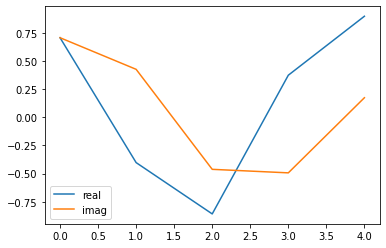

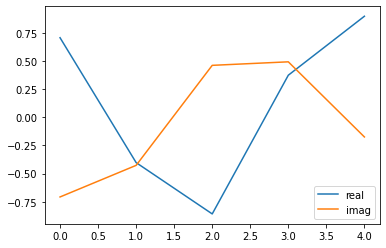

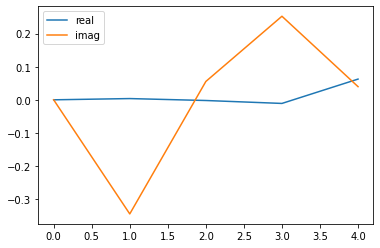

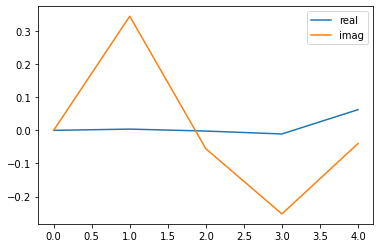

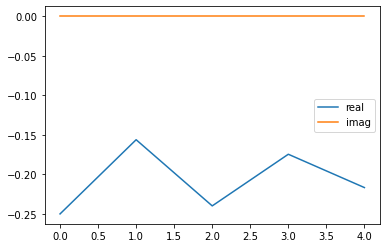

In [1032]:
plt.plot(np.real(creat), label='real')
plt.plot(np.imag(creat), label='imag')
plt.legend()
plt.show()

plt.plot(np.real(annih), label='real')
plt.plot(np.imag(annih), label='imag')
plt.legend()
plt.show()

plt.plot(np.real(sigm), label='real')
plt.plot(np.imag(sigm), label='imag')
plt.legend()
plt.show()

plt.plot(np.real(sigp), label='real')
plt.plot(np.imag(sigp), label='imag')
plt.legend()
plt.show()

plt.plot(np.real(sigz), label='real')
plt.plot(np.imag(sigz), label='imag')
plt.legend()
plt.show()

In [1033]:
x = [(creat[i] + annih[i])/np.sqrt(2) for i in range(len(creat))]
p = [-1j*(creat[i] - annih[i])/np.sqrt(2) for i in range(len(creat))]

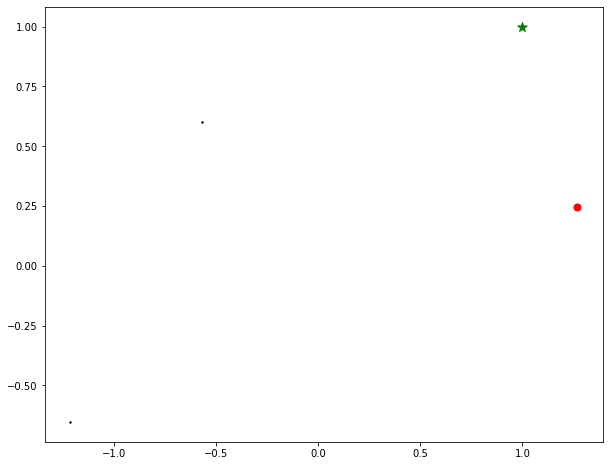

In [1034]:
plt.figure(figsize=(10,8))
plt.scatter(np.real(x)[0], np.real(p)[0], marker='*', c='green', s=100)
plt.scatter(np.real(x)[1:-2], np.real(p)[1:-2], s=2, c='black')
plt.scatter(np.real(x)[-1], np.real(p)[-1], marker='o', c='red', s=50)
#plt.plot(np.real(x), np.real(p), '-', lw= 0.2, c='k')

In [58]:
x

[(1.8746126371150185+0j),
 (1.84917887440337+0j),
 (1.7737648142681999+0j),
 (1.6510138669124361+0j),
 (1.4852661296659393+0j),
 (1.2824450857185692+0j),
 (1.0498739998777546+0j),
 (0.7960072982092816+0j),
 (0.5300701382715378+0j),
 (0.2616124763251777+0j),
 0j,
 (-0.24611976690197346+0j),
 (-0.4693254442153322+0j),
 (-0.663847194213697+0j),
 (-0.8258555005232389+0j),
 (-0.953571069478581+0j),
 (-1.0471735055032116+0j),
 (-1.108511882610584+0j),
 (-1.1406476351349875+0j),
 (-1.14728502774974+0j),
 (-1.1321627008520665+0j),
 (-1.0984881602976273+0j),
 (-1.0484937883728929+0j),
 (-0.9831780036667117+0j),
 (-0.9022704576453008+0j),
 (-0.8044290866944351+0j),
 (-0.6876439626219429+0j),
 (-0.54979307078683+0j),
 (-0.3892728329298734+0j),
 (-0.20561468755041432+0j),
 0j,
 (0.2244012415308772+0j),
 (0.46231914720090594+0j),
 (0.7065213073692742+0j),
 (0.9481879212749778+0j),
 (1.1774839961436352+0j),
 (1.3842646213299437+0j),
 (1.558835351926508+0j),
 (1.6926864870468752+0j),
 (1.779127215545

In [25]:
b = a*start
b

Quantum object: dims = [[10, 2], [1, 1]], shape = (20, 1), type = ket
Qobj data =
[[0.05314317]
 [0.        ]
 [0.13934364]
 [0.        ]
 [0.31859257]
 [0.        ]
 [0.40904734]
 [0.        ]
 [0.83036472]
 [0.        ]
 [0.57041947]
 [0.        ]
 [1.44755931]
 [0.        ]
 [0.40390566]
 [0.        ]
 [1.89643359]
 [0.        ]
 [0.        ]
 [0.        ]]

In [1019]:
from tqdm.notebook import tqdm
psi0 = start
a_s = []
sm_s = []
sz_z = []
nT = 5
for n in tqdm(range(nT)):
    a_s.append((1j*H*n*Tk).expm()*(1j*Hk*n*g).expm()*a*(-1j*Hk*n*g).expm()*(-1j*H*n*Tk).expm())
    sm_s.append(((-1j*H*n*Tk).expm()*(-1j*Hk*n).expm()).conj()*sm*(-1j*Hk*n).expm()*(-1j*H*n*Tk).expm())
    sz_z.append(((-1j*H*n*Tk).expm()*(-1j*Hk*n).expm()).conj()*sz*(-1j*Hk*n).expm()*(-1j*H*n*Tk).expm())
    
beta = []

for i in tqdm(range(len(a_s))):
    beta.append(complex(np.asarray(psi0.trans().conj()*a_s[i]*psi0)))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

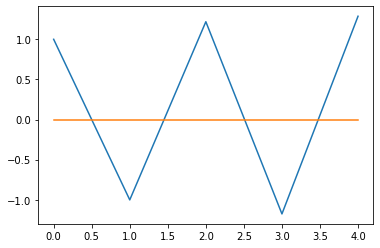

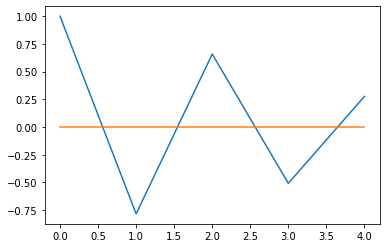

In [1020]:
x = (beta + np.conj(beta))/np.sqrt(2)
p = (np.conj(beta) - beta)*1j/np.sqrt(2)

plt.plot(np.real(x))
plt.plot(np.imag(x))
plt.show()

plt.plot(np.real(p))
plt.plot(np.imag(x))
plt.show()

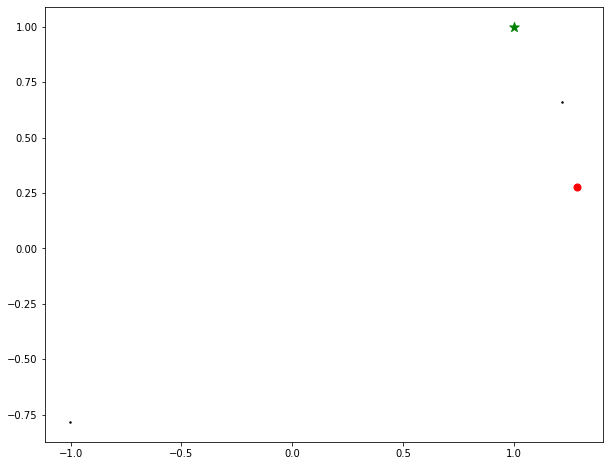

In [1021]:
plt.figure(figsize=(10,8))
plt.scatter(np.real(x)[0], np.real(p)[0], marker='*', c='green', s=100)
plt.scatter(np.real(x)[1:-2], np.real(p)[1:-2], s=2, c='black')
plt.scatter(np.real(x)[-1], np.real(p)[-1], marker='o', c='red', s=50)
#plt.plot(np.real(x), np.real(p), '-', lw= 0.2, c='k')

In [29]:
(-1j*Hk).expm()*((1j*Hk).expm()).conj().trans()

Quantum object: dims = [[10, 2], [10, 2]], shape = (20, 20), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

In [218]:
wc = 1.0  # cavity frequency
wa = 1.0  # atom frequency
#g  = 0.0 * 2 * np.pi  # coupling strength
g = 0.82
kappa = 0.0       # cavity dissipation rate
gamma = 0.0        # atom dissipation rate
N = 25           # number of cavity fock states
n_th_a = 0.0        # avg number of thermal bath excitation
use_rwa = True

T = 2*np.pi / wc
r = 1/3
Tk = r * T
mu = 20
x = 1
p = 1
alpha0 = (1j*p + x) / np.sqrt(2)
#g = np.sqrt(2*wc)*g
# operators
a  = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), create(2))
sx = tensor(qeye(N), sigmax()) 
sp = sm.dag()
sz = sp*sm - sm*sp
sz = tensor(qeye(N), sigmaz()) 
# Hamiltonian
if use_rwa:
    H = wc * a.dag() * a + wa * sz/2 + g * (a.dag()*sm + a*sp)
else:
    H = wc * a.dag() * a + wa * sp*sm + g * (a.dag() + a) * (sm + sm.dag())
#print(H)
Hk = (np.conj(mu)*sm + mu*sp)
#print(Hk)
start = np.sqrt(2/2)*tensor(coherent(N,alpha0), basis(2,0))

In [219]:
nT = 200
ava = []
avsm = []
avsz = []
for n in tqdm(range(nT)):
    rho = ket2dm(start)
    dotrho = (1j*H*n*Tk + 1j*Hk*n).expm()*rho*(-1j*Hk*n - 1j*H*n*Tk).expm()
    rho_field = ptrace(dotrho, 0)
    rho_qubit = ptrace(dotrho, 1)
    ava.append((rho_field*destroy(N)).tr())
    avsm.append((rho_qubit*sigmam()).tr())
    avsz.append((rho_qubit*sigmaz()).tr())
avada = np.conj(ava)
avsp = np.conj(avsm)
x = (ava + avada)/np.sqrt(2)
p = (avada - ava)*1j/np.sqrt(2)

100%|██████████| 200/200 [00:02<00:00, 85.83it/s]


In [220]:
#print(x)
#print(p)

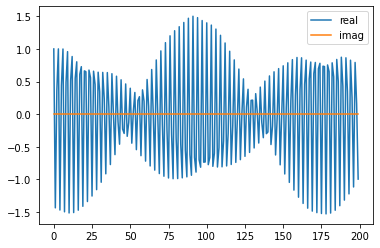

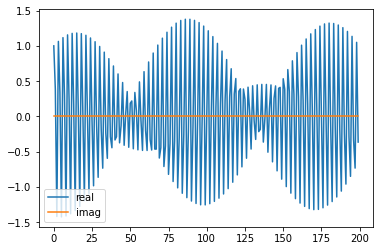

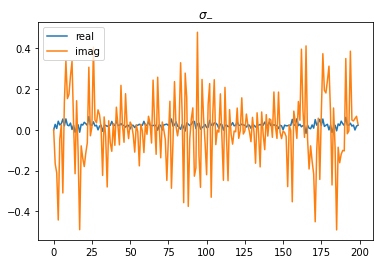

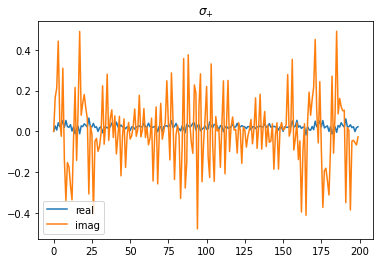

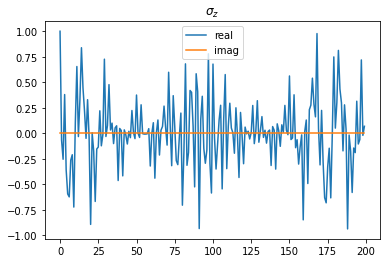

In [221]:
plt.plot(np.real(x), label='real')
plt.plot(np.imag(x), label='imag')
plt.legend()
plt.show()

plt.plot(np.real(p), label='real')
plt.plot(np.imag(p), label='imag')
plt.legend()
plt.show()

plt.plot(np.real(avsm), label='real')
plt.plot(np.imag(avsm), label='imag')
plt.title('$\sigma_{-}$')
plt.legend()
plt.show()

plt.plot(np.real(avsp), label='real')
plt.plot(np.imag(avsp), label='imag')
plt.title('$\sigma_{+}$')
plt.legend()
plt.show()

plt.plot(np.real(avsz), label='real')
plt.plot(np.imag(avsz), label='imag')
plt.title('$\sigma_{z}$')
plt.legend()
plt.show()

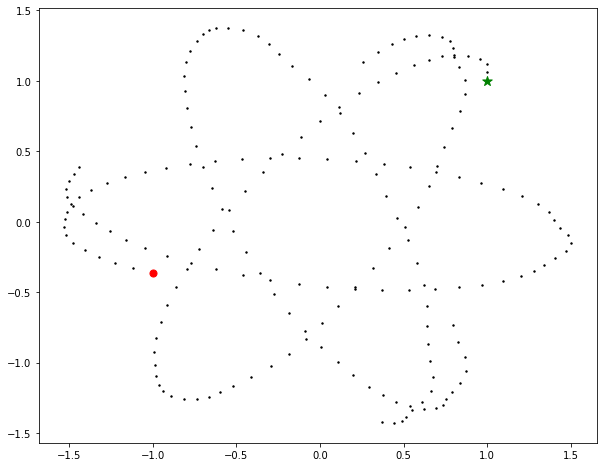

In [222]:
plt.figure(figsize=(10,8))
plt.scatter(np.real(x)[0], np.real(p)[0], marker='*', c='green', s=100)
plt.scatter(np.real(x)[1:-2], np.real(p)[1:-2], s=2, c='black')
plt.scatter(np.real(x)[-1], np.real(p)[-1], marker='o', c='red', s=50)
#plt.plot(np.real(x), np.real(p), '-', lw= 0.2, c='k')